In [331]:
%%time
import importlib
import pandas as pd
import scipy as scp
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns

import SRRS
from SRRS import plotting, utils

# Make three-panel plots for significant gene/metrics

In [404]:
%%time
#read in all gene/cell info for both mice over all metrics (this is a large table)
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
gene_cell_df = pd.concat((
    pd.read_csv(p, usecols=['metric','annotation','gene','score','num_gene_spots'])
    for p in all_BICCN_gene_cells
))
gene_cell_df

CPU times: user 19.6 s, sys: 1.61 s, total: 21.3 s
Wall time: 22.4 s


metric annotation     gene  num_gene_spots     score
0         puncta       Endo   Cxcl14               3 -0.488000
1         puncta       Endo     Flt1              66  0.458000
2         puncta       Endo     Aqp4               2 -0.250000
3         puncta       Endo    Acta2               3 -0.848000
4         puncta       Endo    Timp3              17  0.566000
...          ...        ...      ...             ...       ...
4669863  central      L5_IT  Tmem163               1 -0.303371
4669864  central      L5_IT      Tox               9 -0.198502
4669865  central      L5_IT    Trpc4               3 -0.820225
4669866  central      L5_IT    Wipf3              14 -0.033708
4669867  central      L5_IT    Wnt7b               1  0.857678

[35713648 rows x 5 columns]

In [360]:
%%time
#creating subsetted gtf to prepare for ReadZs score extraction

#this bam is from BICCN_10Xv3 has cell-type and sample of origin information as XO and RG tags respectively
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
    
#mouse gtf file to be able to plot exons/introns/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')

#Fam19a2 gene synonym Tafa2 is used in the gtf. changing it to match the gene/cell table
#Fam84b gene synonym Lratd2 is used in the gtf. changing it to match the gene/cell table
gtf.loc[gtf['label'].eq('Tafa2'),'label'] = 'Fam19a2'
gtf.loc[gtf['label'].eq('Lratd2'),'label'] = 'Fam84b'

#Get the MERFISH gene names from the gene_ont outputs
gene_ont_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*')
BICCN_genes_df = pd.concat((pd.read_csv(p, usecols=['gene']) for p in gene_ont_paths), ignore_index=True)
BICCN_genes = set(BICCN_genes_df['gene'])

#sanity checking gene labels match between GTF and spatial
#Determine how many genes are present in both the gtf and the gene/cell table
gtf_genes = set(gtf['label'])
shared_genes = BICCN_genes.intersection(gtf_genes)
BICCN_only_genes = BICCN_genes.difference(gtf_genes)

print('There are',len(gtf_genes),'unique genes in the gtf')
print('There are',len(BICCN_genes),'unique genes in the gene/cell table')
print('There are',len(shared_genes),'genes shared between both')
print('Genes present only in the gene/cell table',BICCN_only_genes)

#subset the gtf to just the entries with the shared genes
gtf = gtf[gtf['label'].isin(shared_genes)]

#have to 'manually' distinguish between 5' and 3' UTRs
for (transcript_id,strand),t in gtf.groupby(['group','strand']):
    if strand == '+':
        utr3_start = t[t['kind'].eq('exon')]['end'].max()
        utr_3s = t[t['kind'].eq('UTR') & t['end'].ge(utr3_start)]
    elif strand == '-':
        utr3_start = t[t['kind'].eq('exon')]['start'].min()
        utr_3s = t[t['kind'].eq('UTR') & t['start'].le(utr3_start)]
    else:
        sys.stderr.write('strand error\n')
        break
        
    gtf.loc[utr_3s.index,'kind'] = '3UTR'


#Determine which loci to plot by:
#1) selecting genes that are in both the gtf and the gene/cell table
#2) selecting on UTRs
#3) grouping by gene and expanding left to the 5'-most UTR start, and right to the 3'-most UTR end
#   this is important for genes with multiple annotated 3' UTRs
#4) add a bit of "padding" on either side of the locus as 1% of the span
loci = gtf[
    gtf['label'].isin(shared_genes) &
    gtf['kind'].eq('3UTR')
][['label','chrom','start','end','strand']].drop_duplicates()

loci = loci.groupby(['label','chrom','strand']).agg(
    start = ('start','min'),
    end = ('end','max'),
).reset_index()

padding = loci['end'].subtract(loci['start']).multiply(0.01).astype(int)
loci['start'] -= padding
loci['end'] += padding

print('There are',len(loci),'loci to use for plotting')

There are 55228 unique genes in the gtf
There are 252 unique genes in the gene/cell table
There are 242 genes shared between both
Genes present only in the gene/cell table {'Blank-5', 'Blank-3', 'Blank-10', 'Blank-2', 'Blank-7', 'Blank-9', 'Blank-4', 'Blank-8', 'Blank-1', 'Blank-6'}
There are 241 loci to use for plotting
CPU times: user 14 s, sys: 638 ms, total: 14.7 s
Wall time: 54.9 s


In [393]:
sig_gene_metrics = pd.DataFrame({'gene': ['Timp3',
  'Chn2',
  'Chn2',
  'Chn2',
  'Chn2',
  'Asic4',
  'Asic4',
  'Rgs6',
  'Rgs6',
  'Rgs6',
  'Rgs6',
  'Slc32a1',
  'Slc32a1',
  'Nr2f2',
  'Nr2f2',
  'Nr2f2',
  'Tbc1d4',
  'Tbc1d4',
  'Dscaml1',
  'Dscaml1',
  'Meis2',
  'Meis2',
  'Meis2',
  'Meis2',
  'Cxcl14',
  'Cxcl14',
  'Cxcl14',
  'Nxph1',
  'Nxph1',
  'Pcdh8',
  'Nkain3',
  'Nr4a1',
  'Satb2',
  'Satb2',
  'Satb2',
  'Satb2',
  'Cdh13',
  'Cdh13',
  'Camk2d',
  'Rnf152',
  'Prss23',
  'Igfbp4',
  'Igfbp4',
  'Igfbp4',
  'Igfbp4',
  'Shisa9',
  'Shisa9',
  'Shisa9',
  'Shisa9',
  'Slc30a3',
  'Slc30a3',
  'Slc30a3',
  'Igfbp5',
  'Wipf3',
  'Wipf3',
  'Wipf3',
  'Wipf3',
  'Trp53i11',
  'Trp53i11',
  'Trp53i11',
  'Marcksl1'],
 'metric': ['periph',
  'central',
  'periph',
  'puncta',
  'radial',
  'central',
  'periph',
  'central',
  'periph',
  'puncta',
  'radial',
  'puncta',
  'radial',
  'periph',
  'puncta',
  'radial',
  'puncta',
  'radial',
  'periph',
  'central',
  'central',
  'periph',
  'puncta',
  'radial',
  'radial',
  'periph',
  'central',
  'central',
  'periph',
  'radial',
  'central',
  'radial',
  'central',
  'periph',
  'puncta',
  'radial',
  'puncta',
  'radial',
  'central',
  'puncta',
  'puncta',
  'radial',
  'puncta',
  'central',
  'periph',
  'radial',
  'puncta',
  'periph',
  'central',
  'central',
  'periph',
  'radial',
  'radial',
  'central',
  'periph',
  'puncta',
  'radial',
  'central',
  'periph',
  'radial',
  'radial']})

sig_gene_metrics

gene   metric
0      Timp3   periph
1       Chn2  central
2       Chn2   periph
3       Chn2   puncta
4       Chn2   radial
..       ...      ...
56     Wipf3   radial
57  Trp53i11  central
58  Trp53i11   periph
59  Trp53i11   radial
60  Marcksl1   radial

[61 rows x 2 columns]

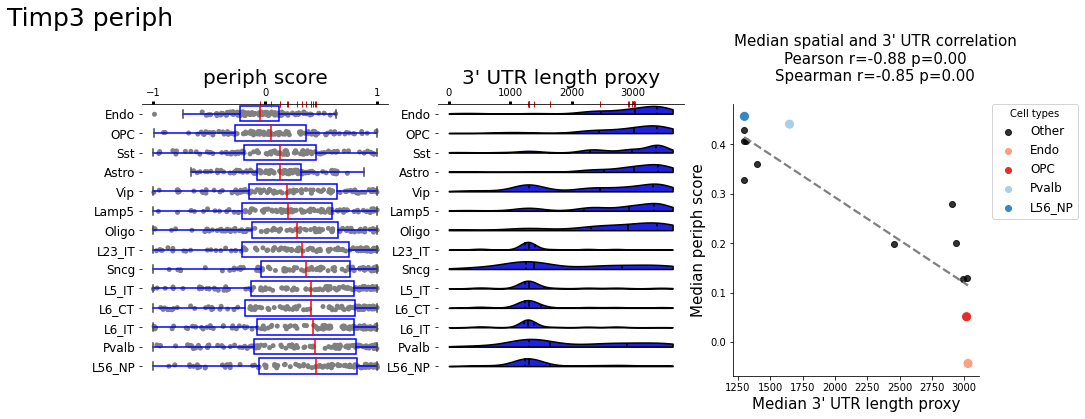

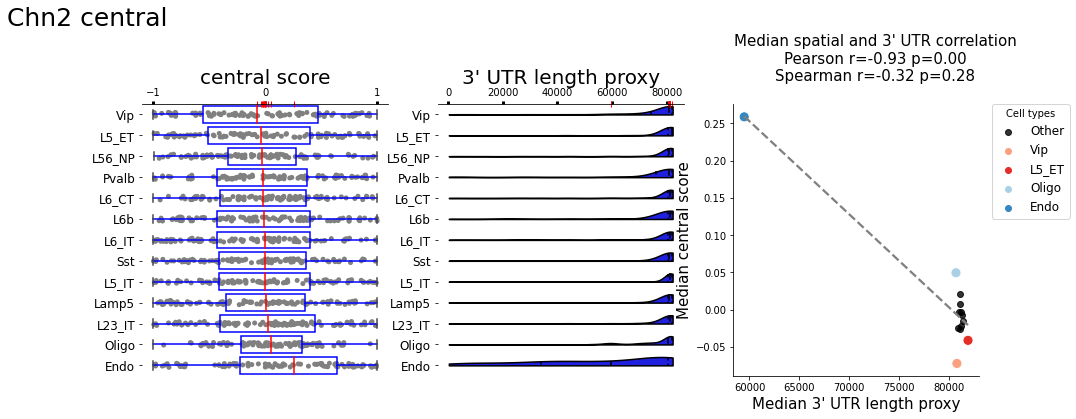

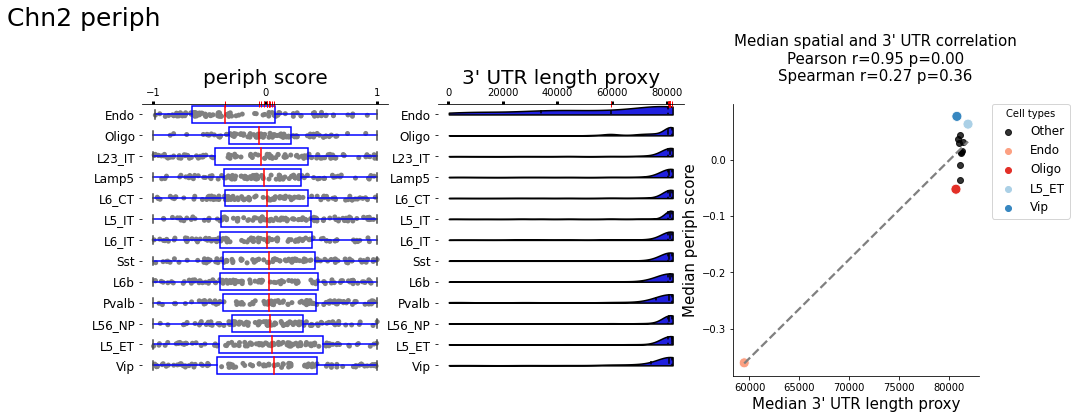

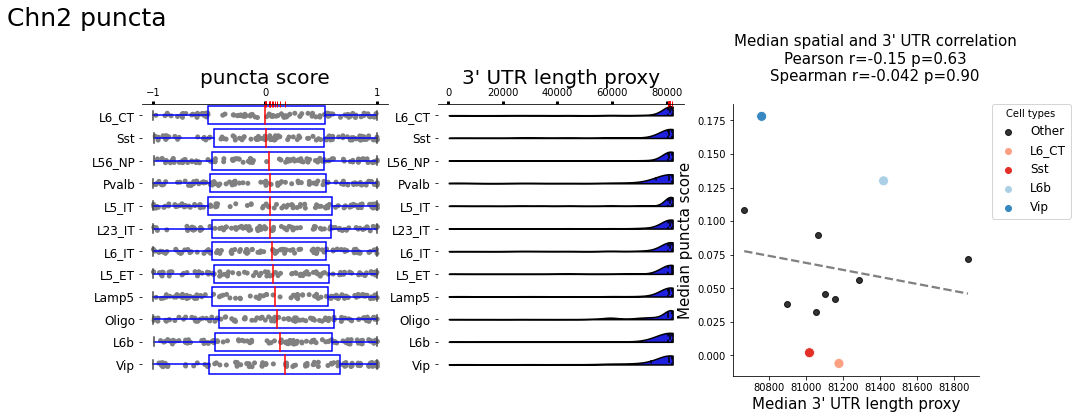

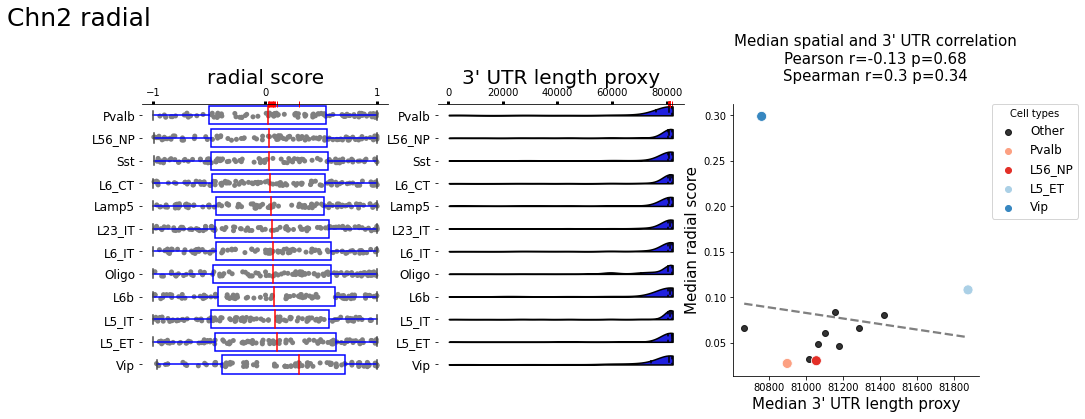

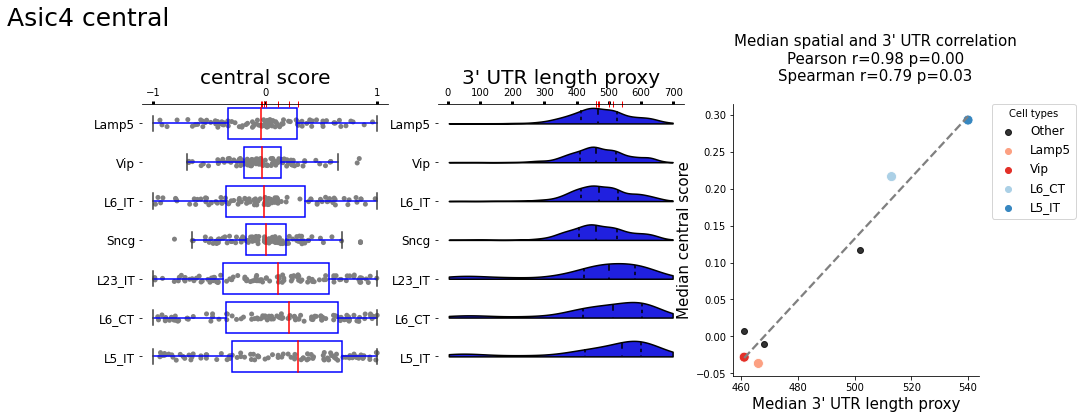

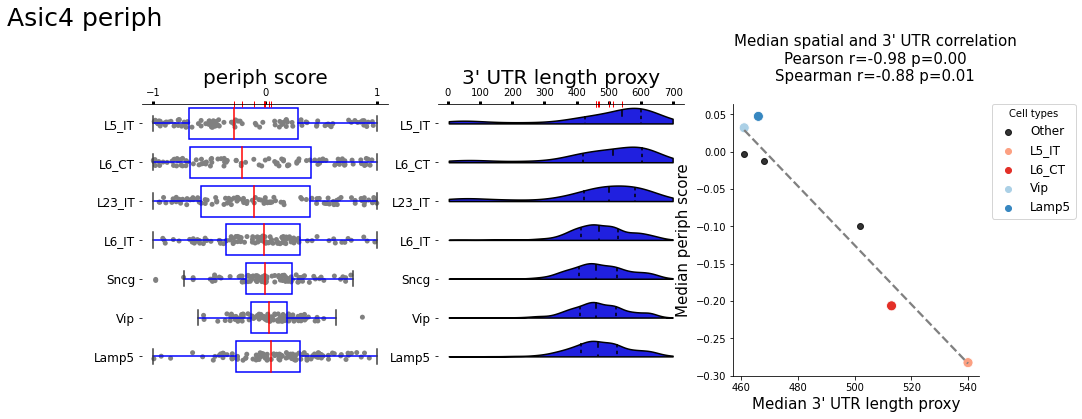

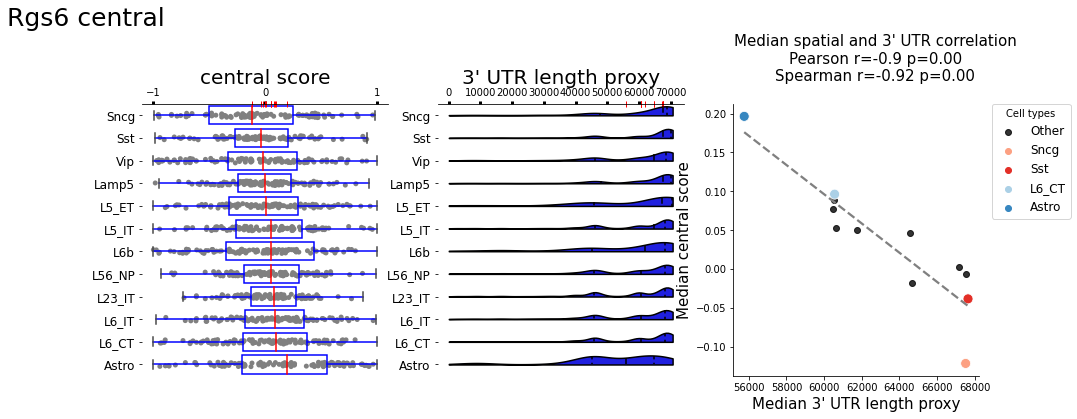

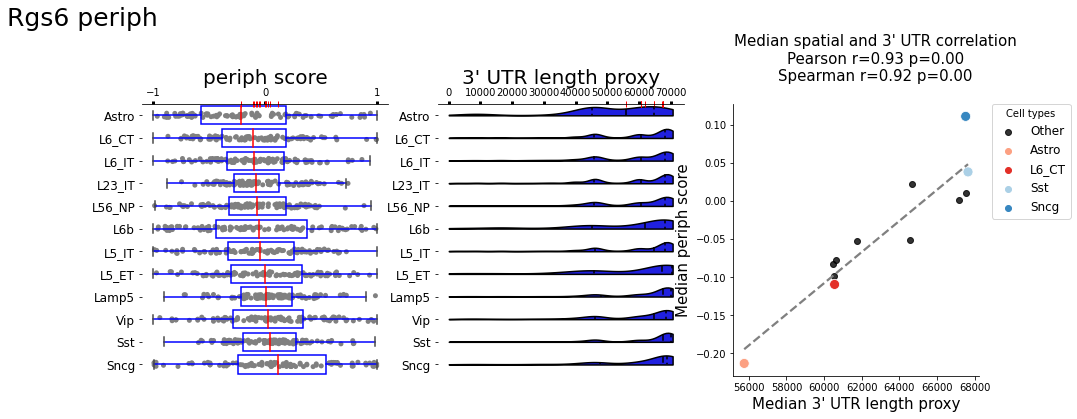

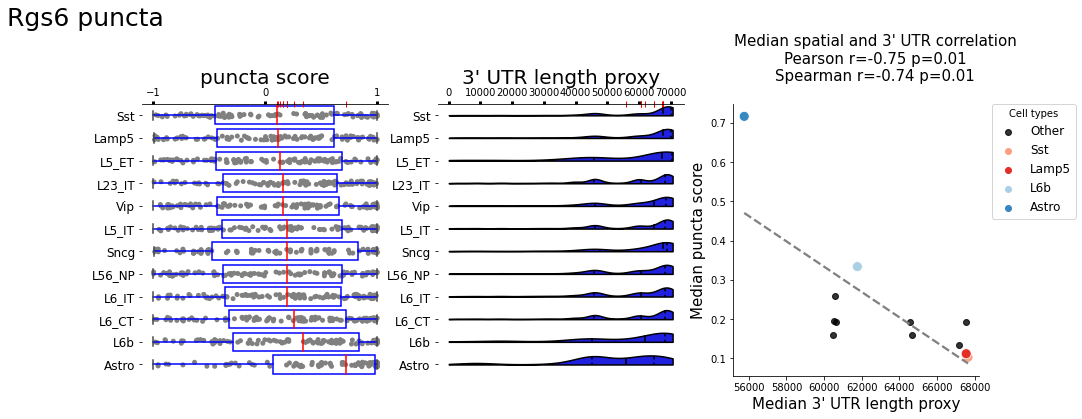

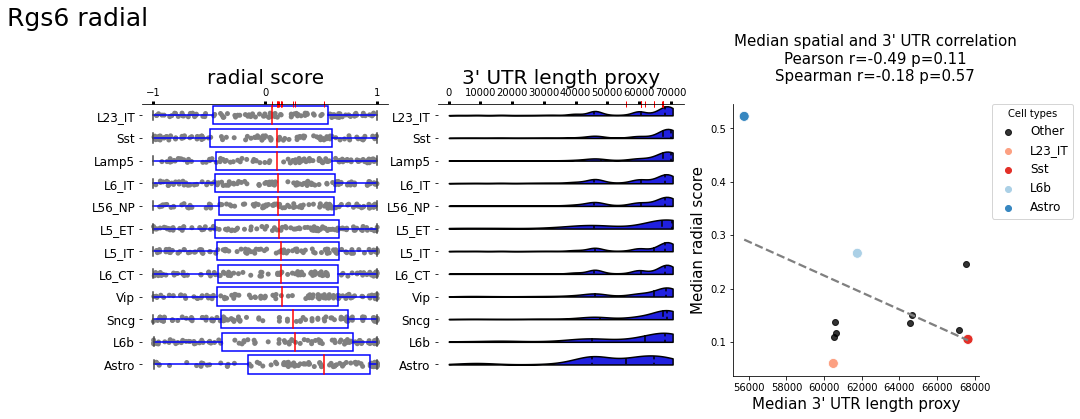

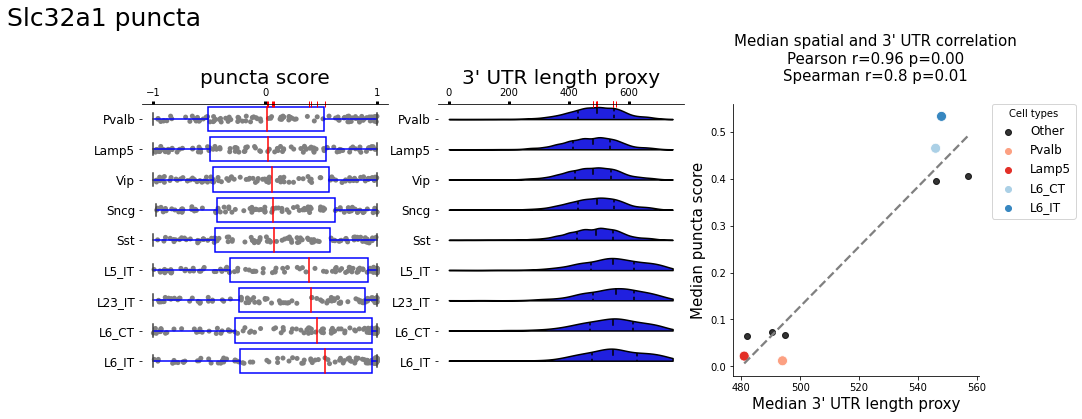

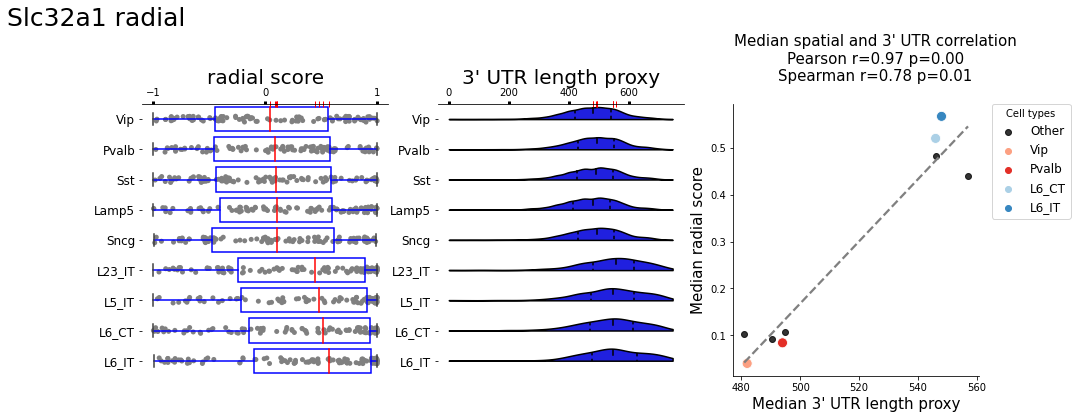

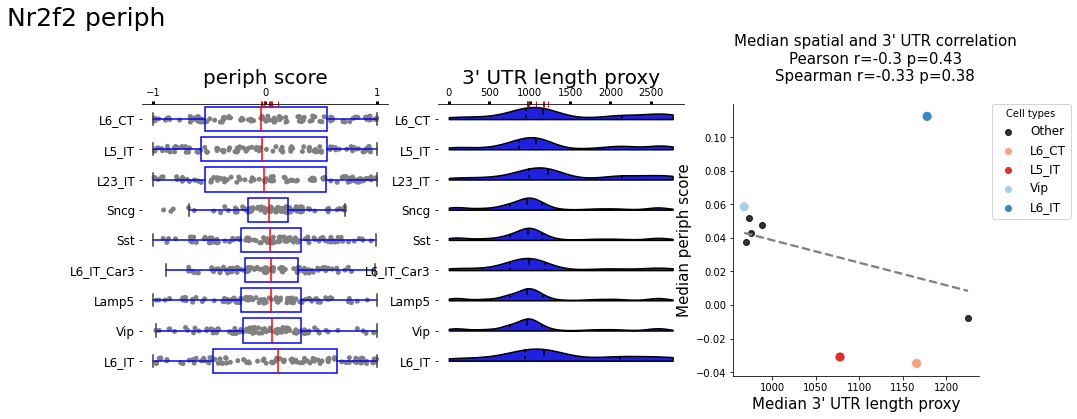

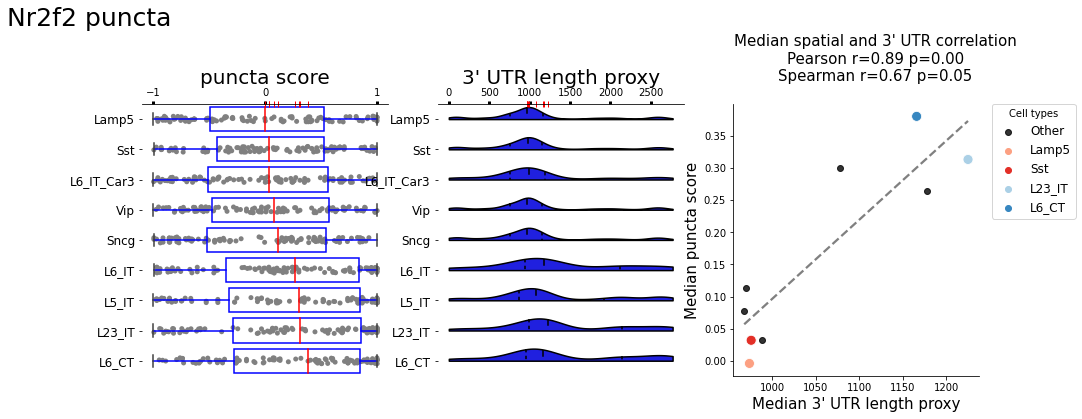

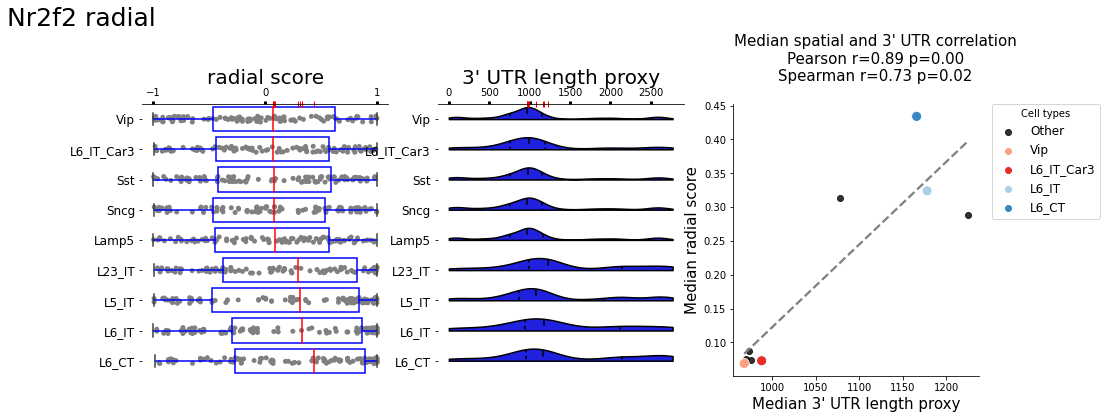

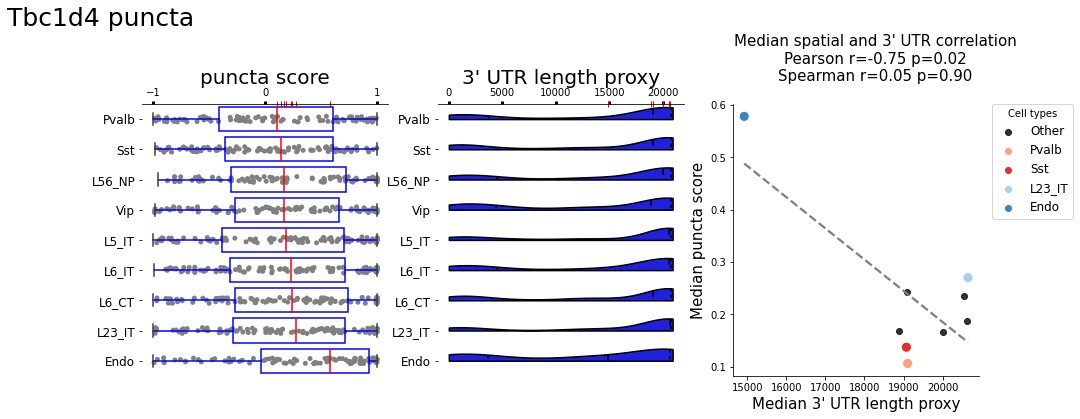

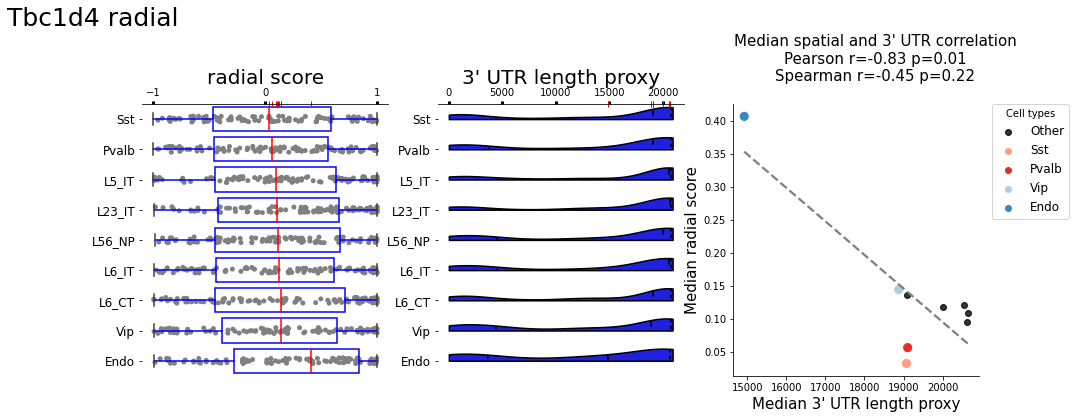

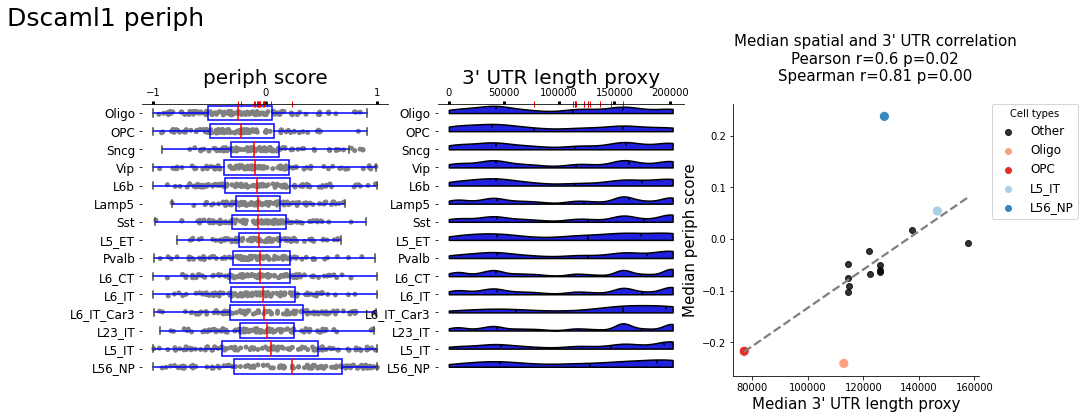

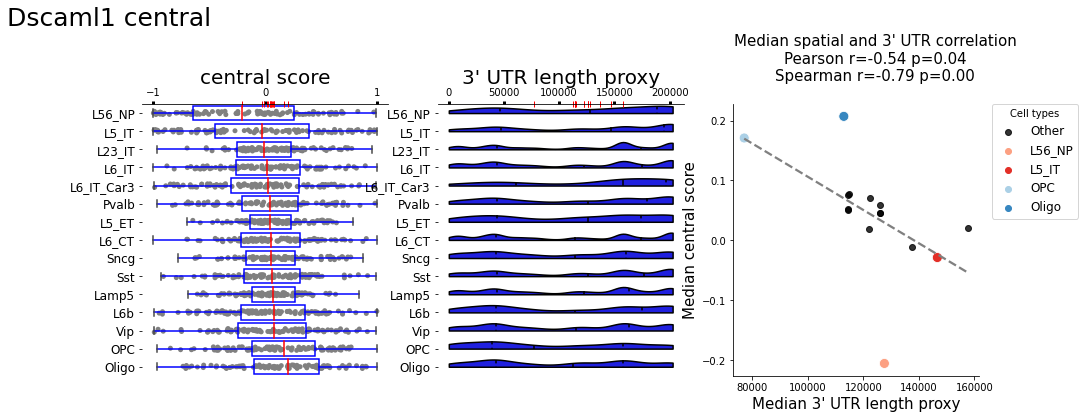

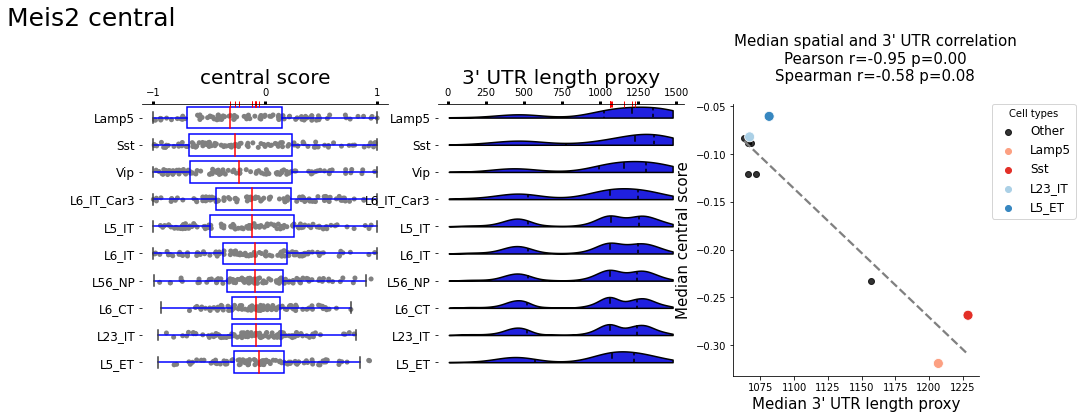

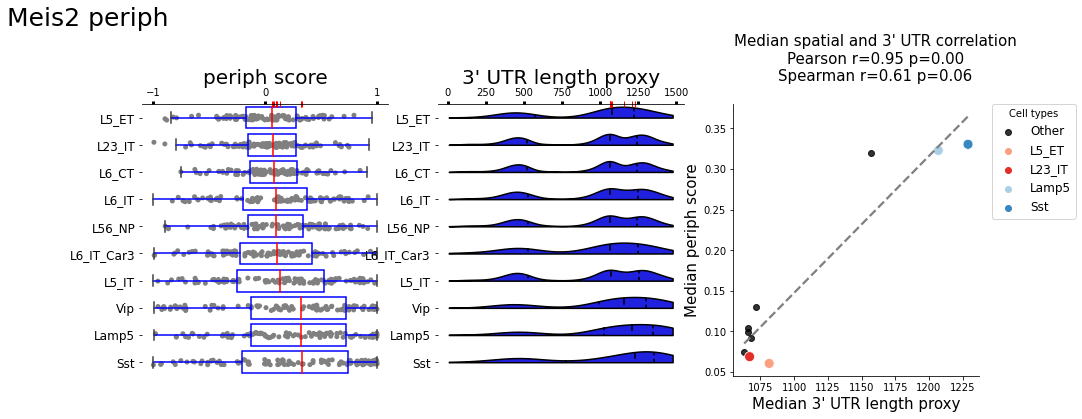

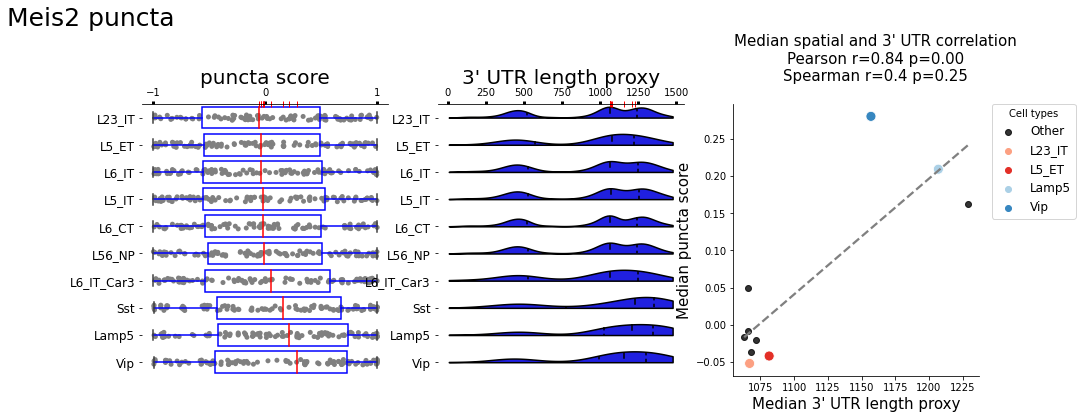

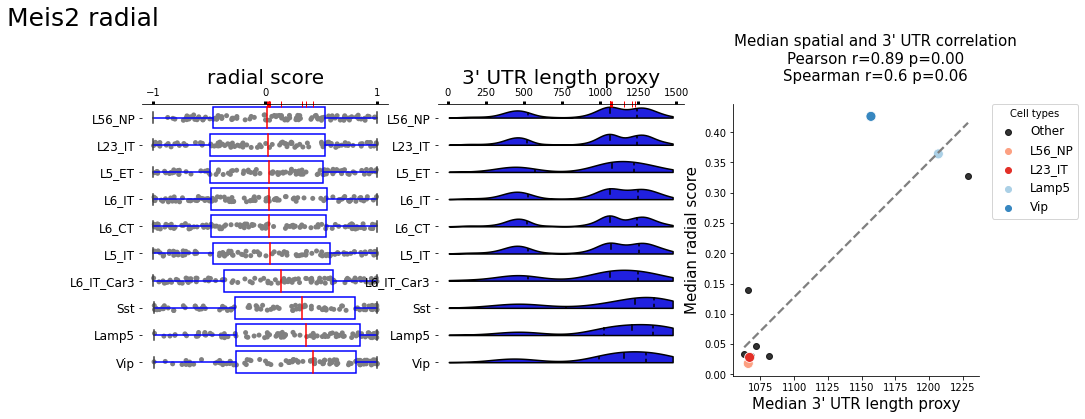

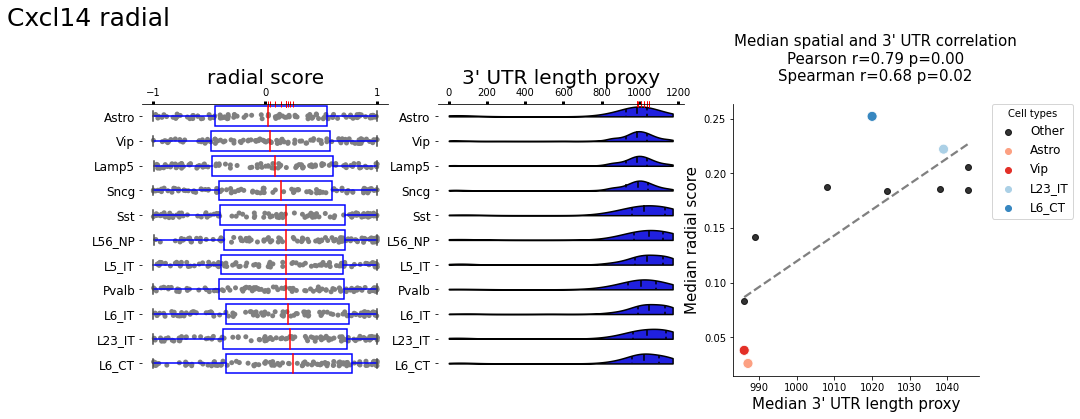

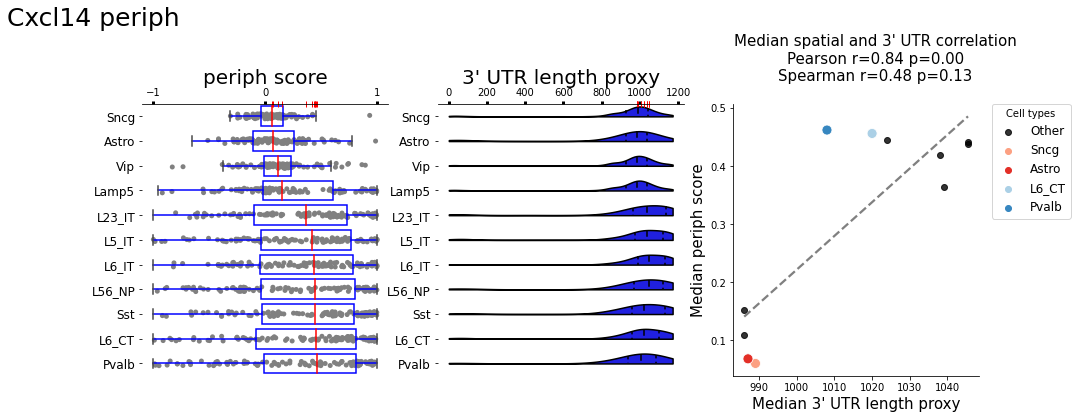

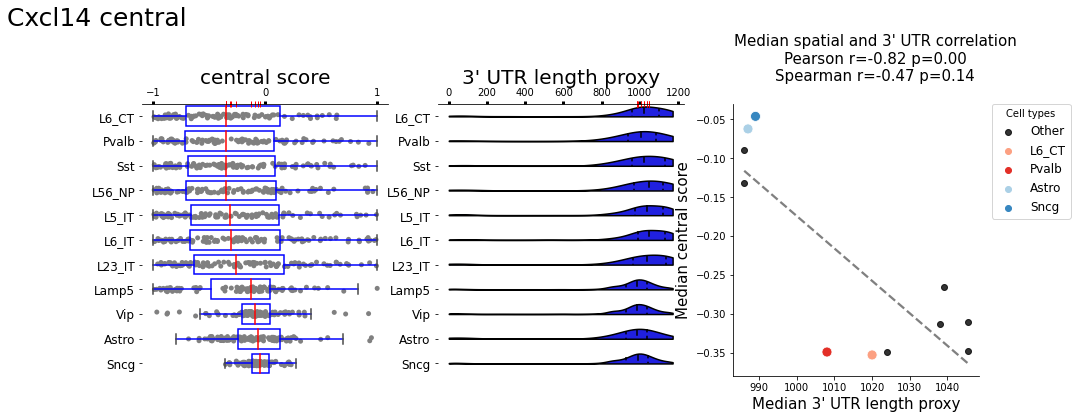

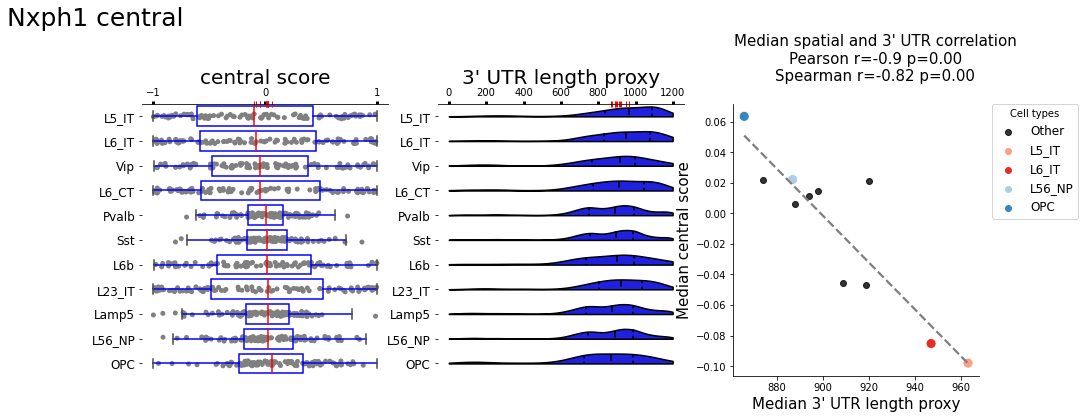

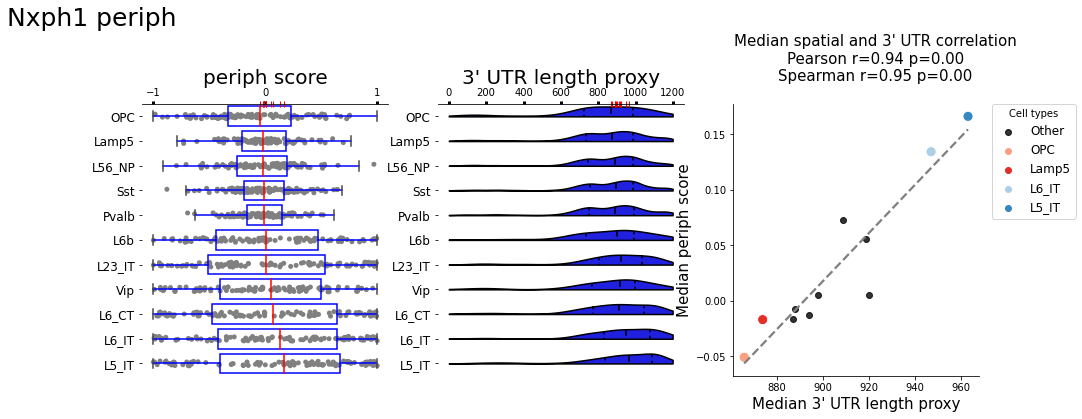

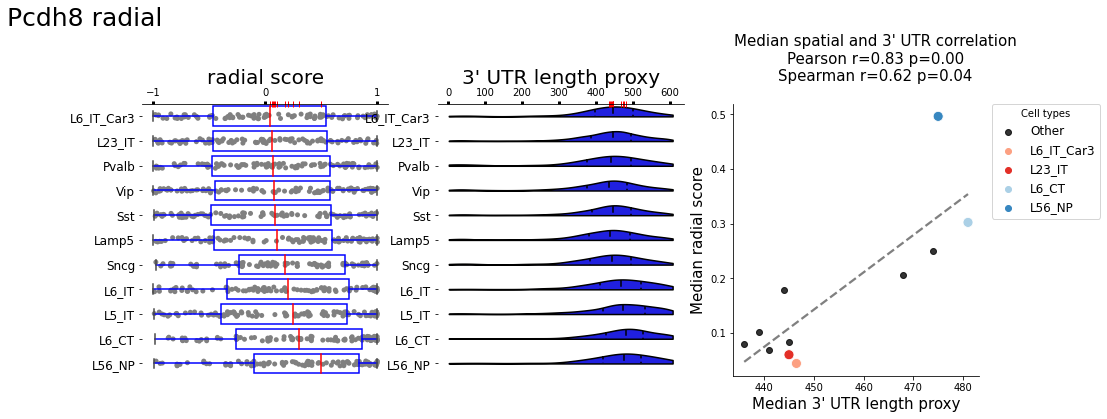

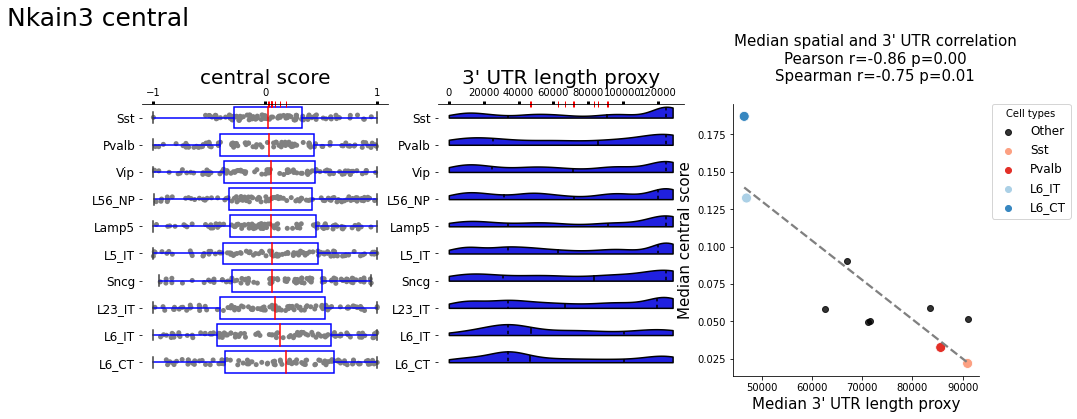

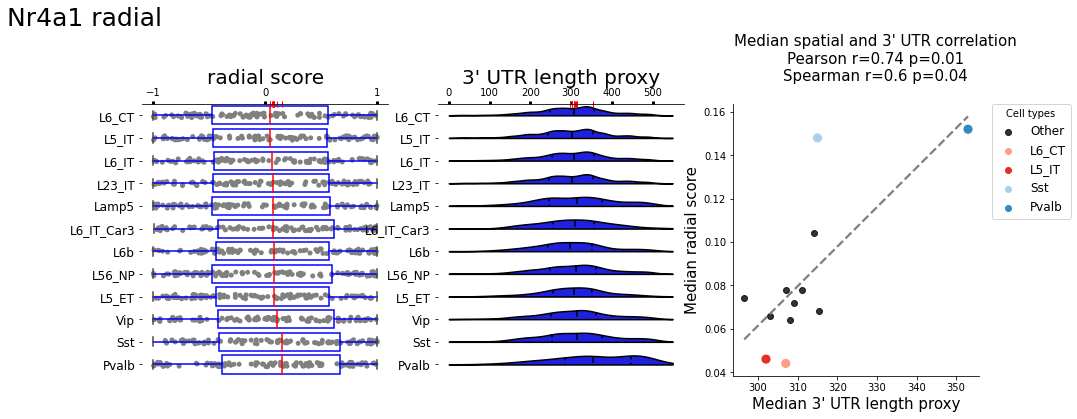

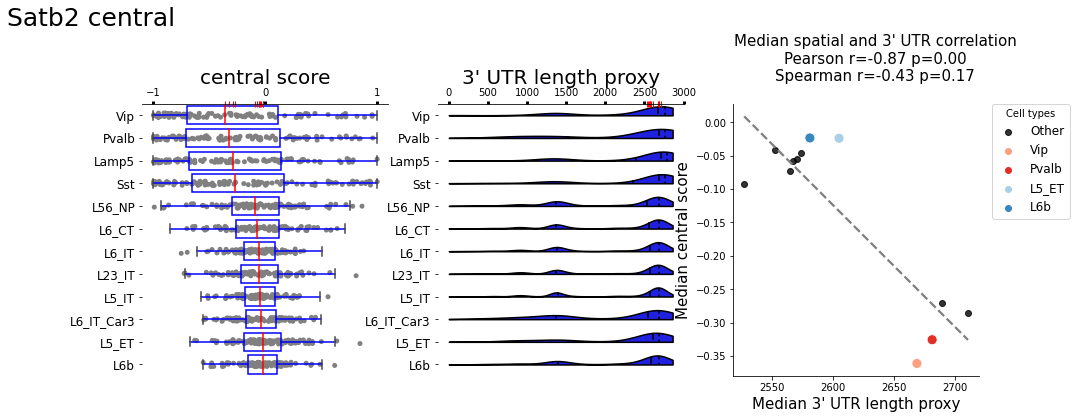

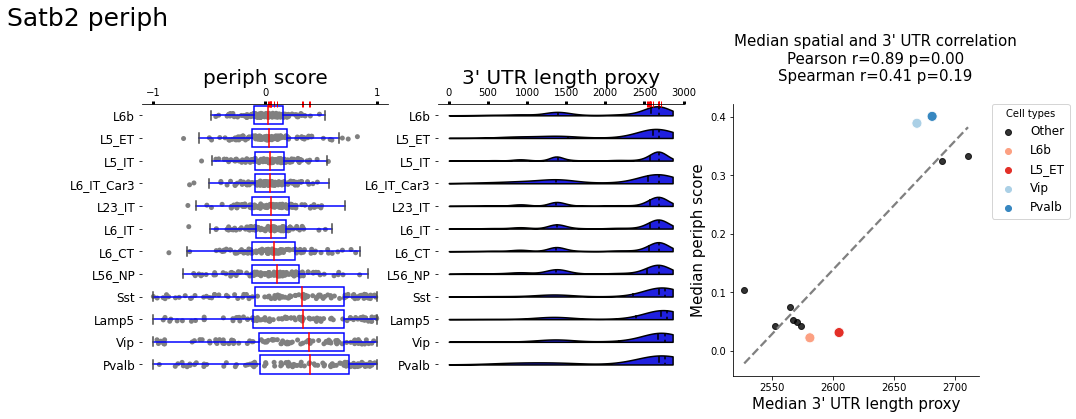

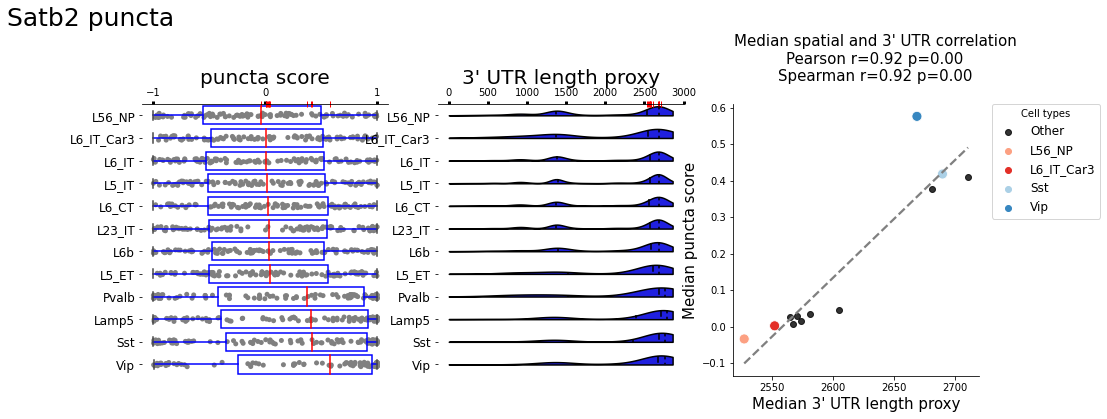

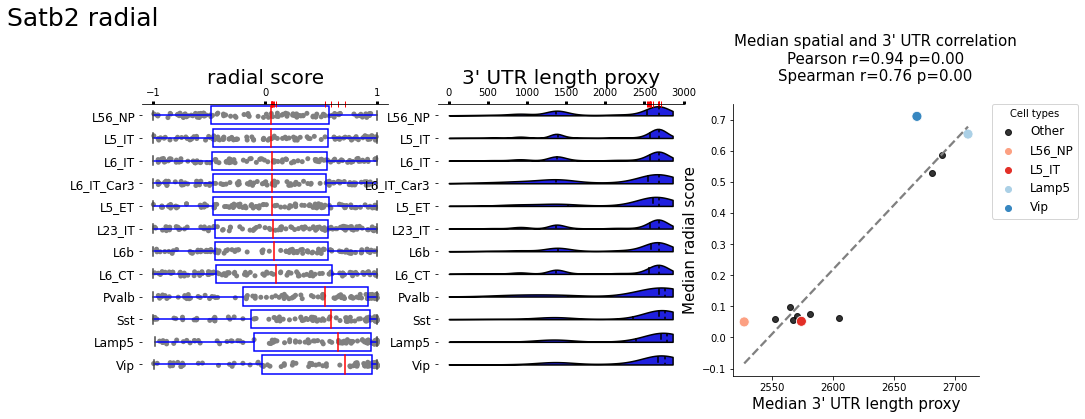

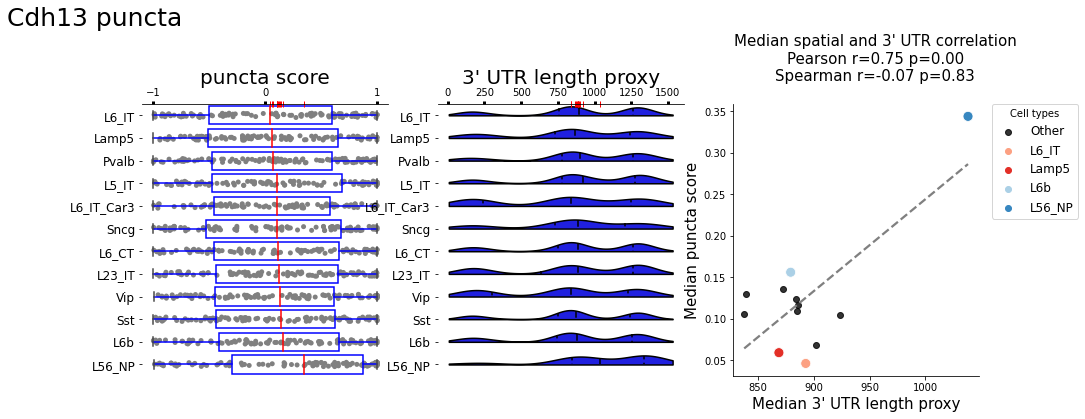

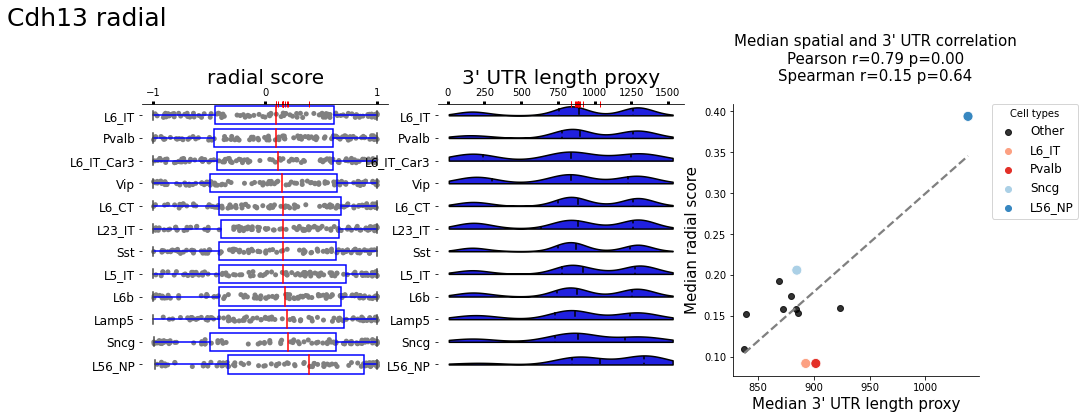

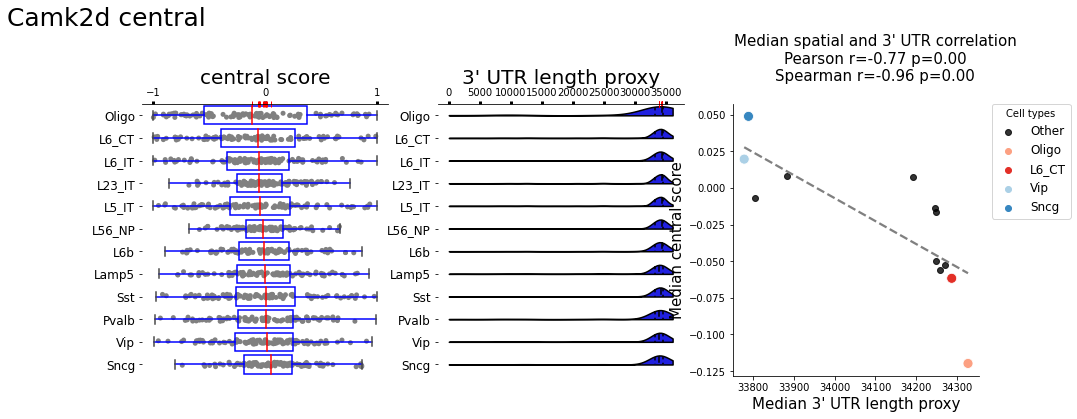

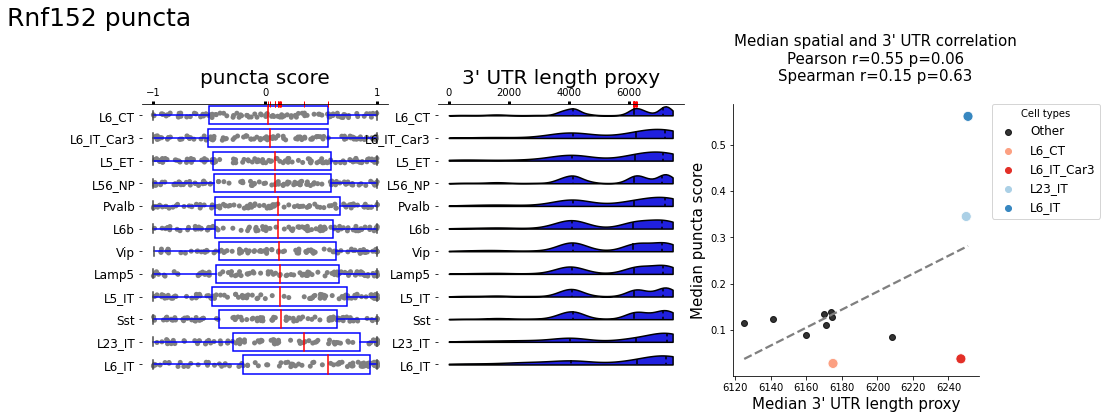

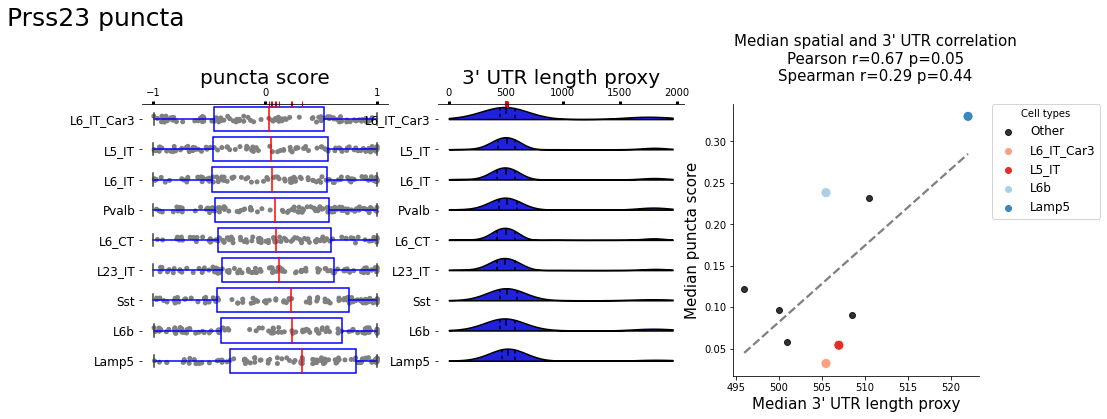

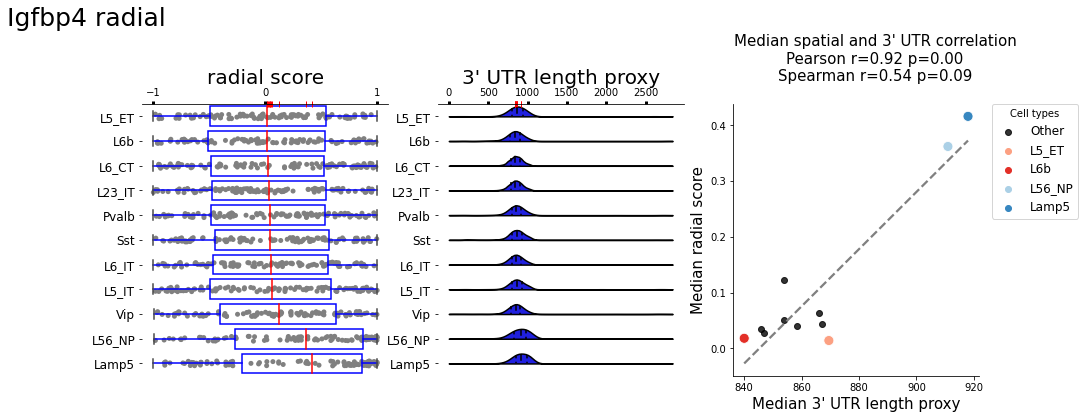

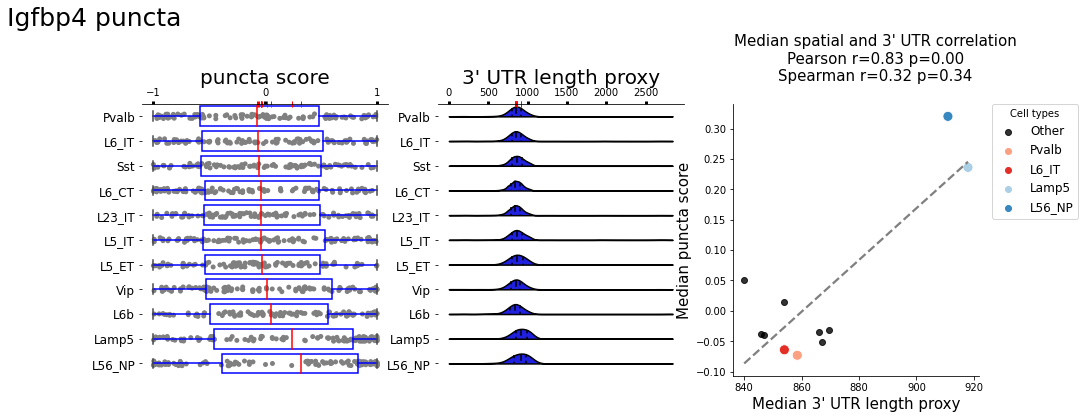

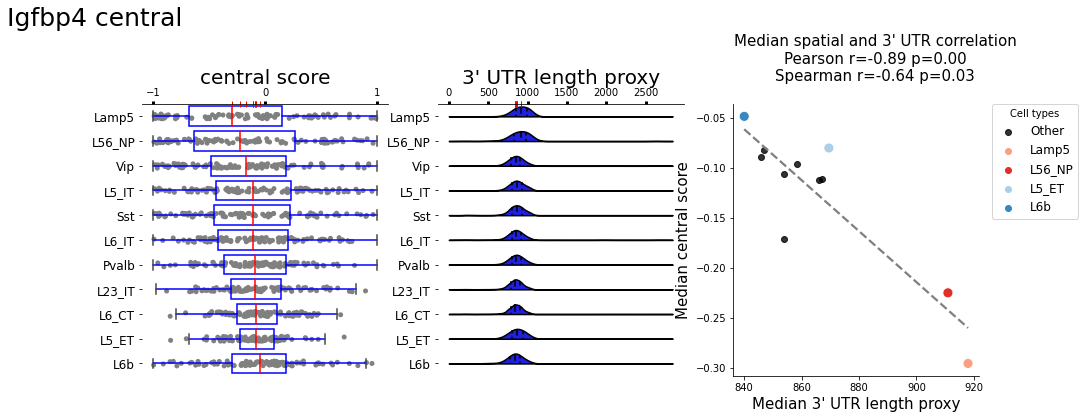

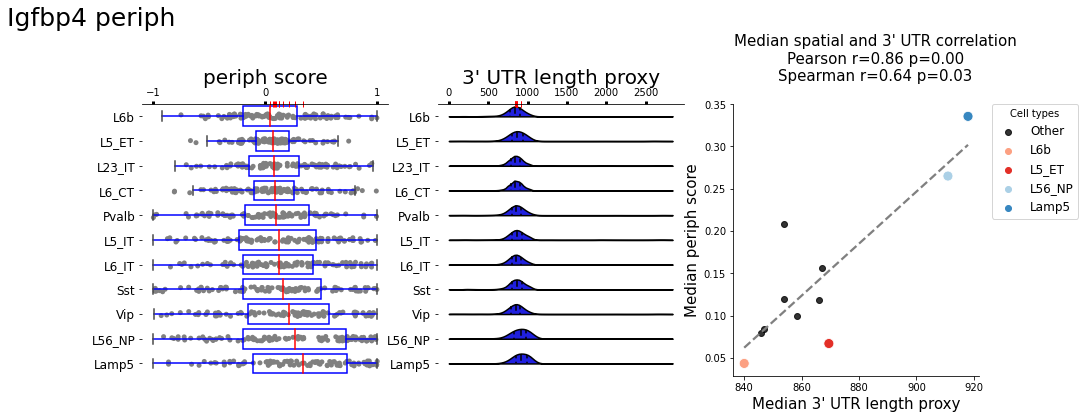

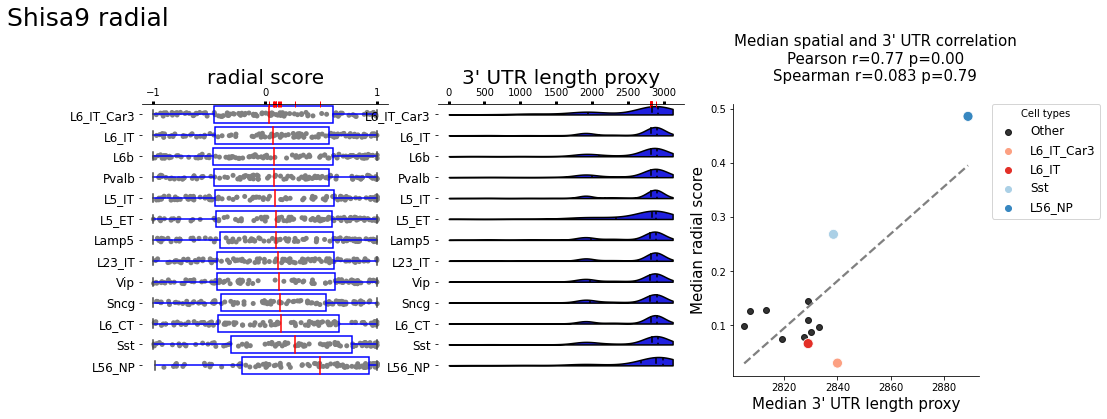

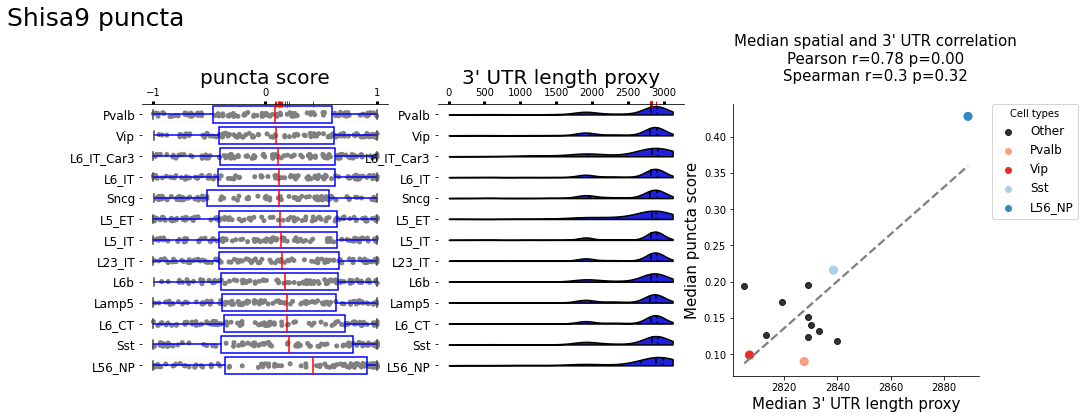

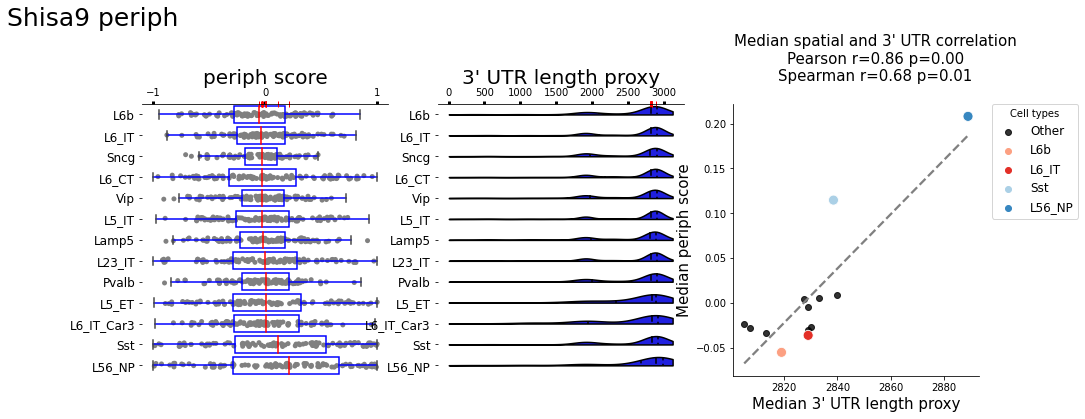

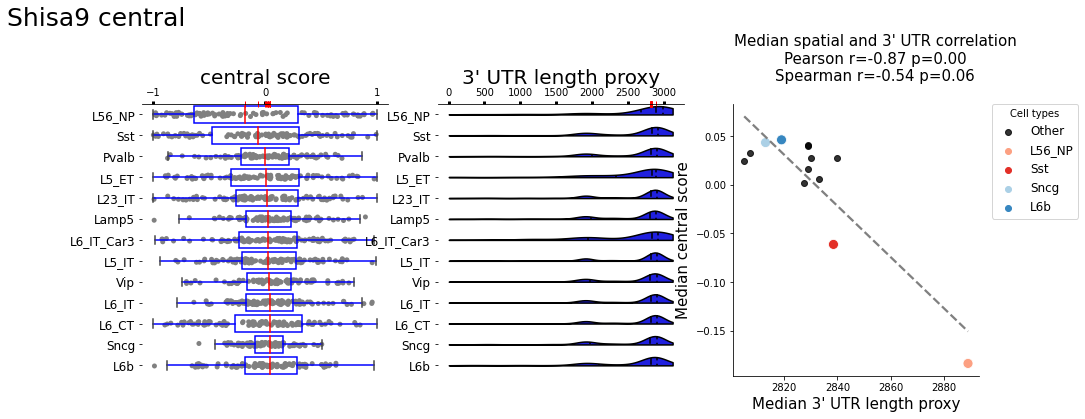

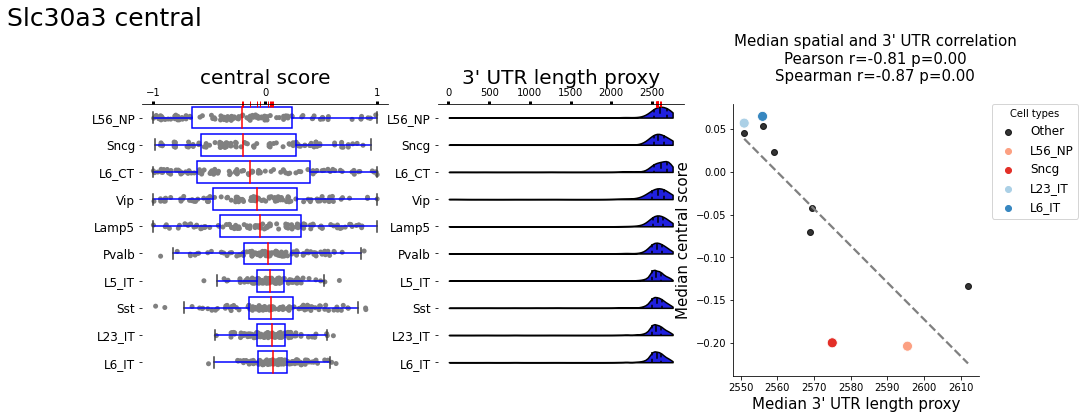

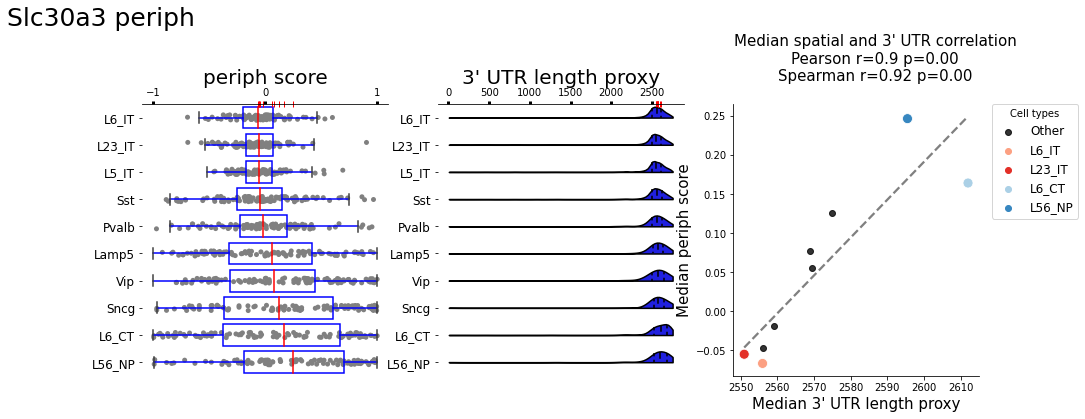

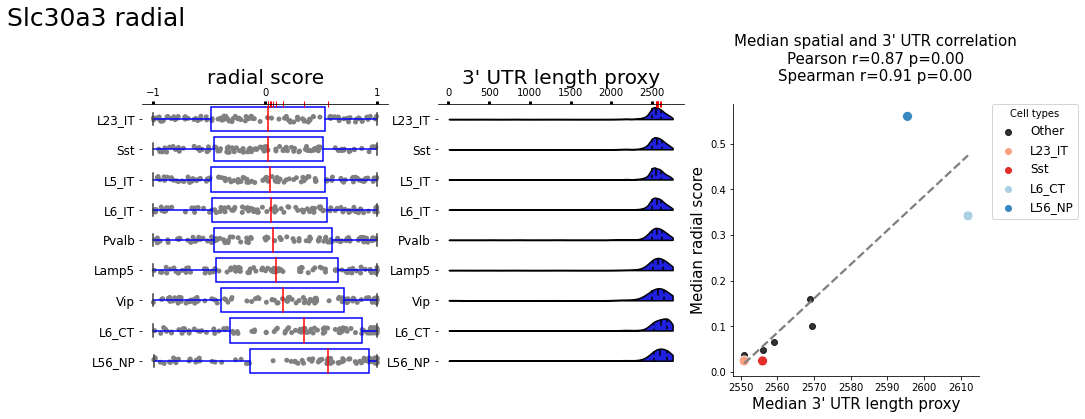

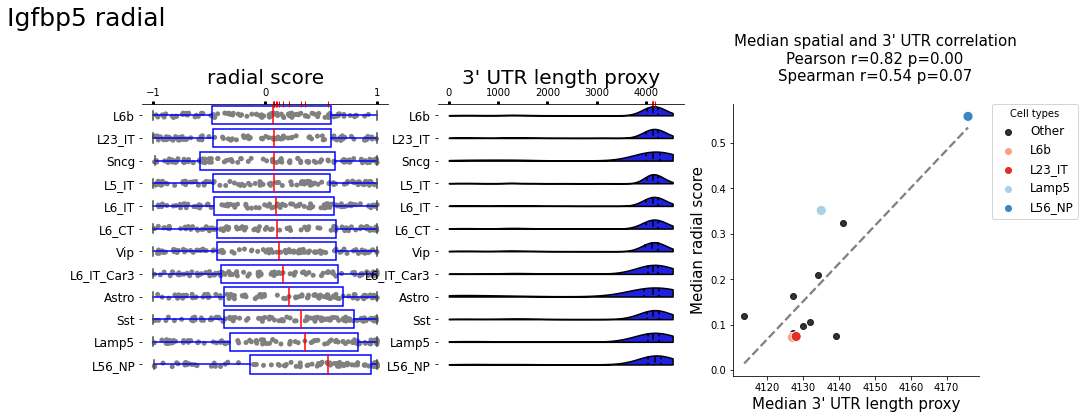

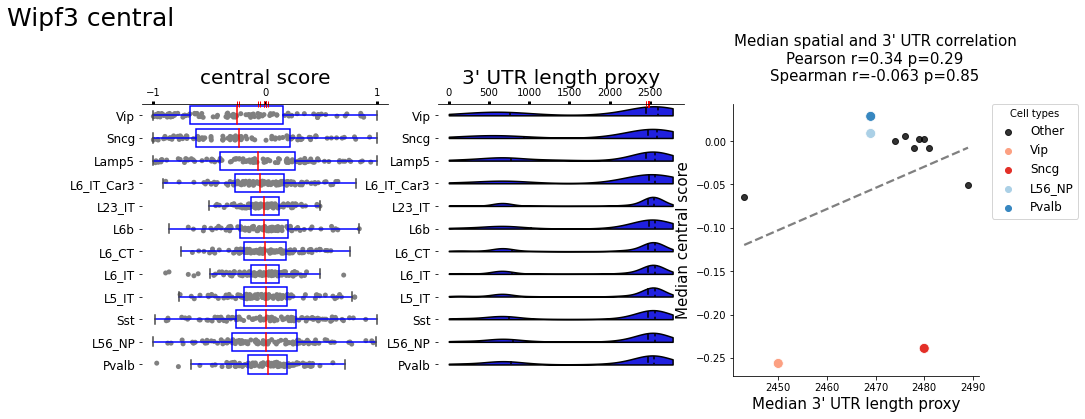

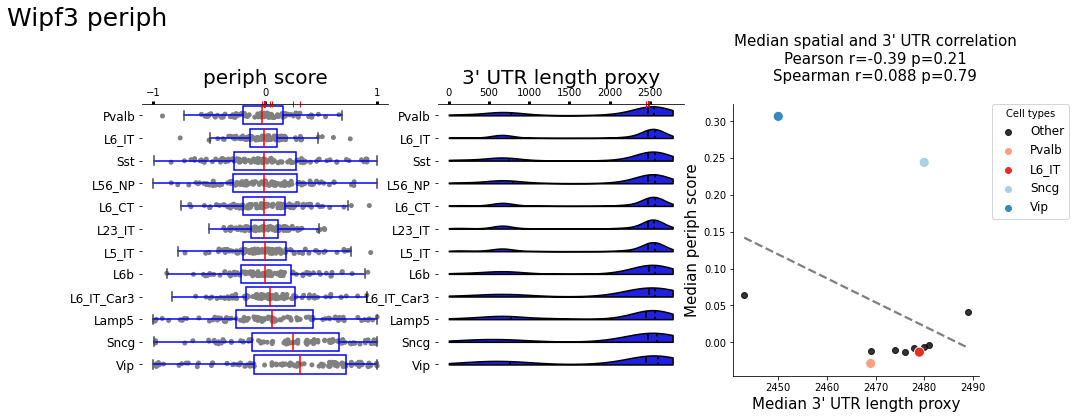

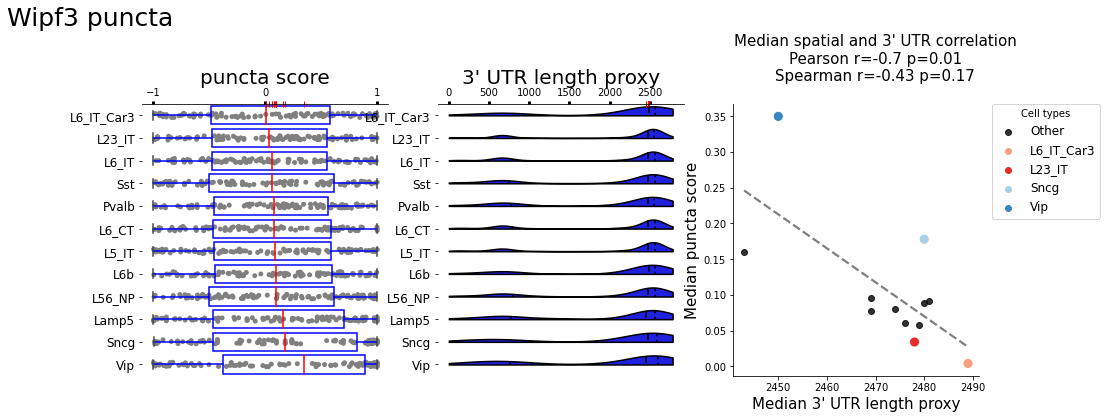

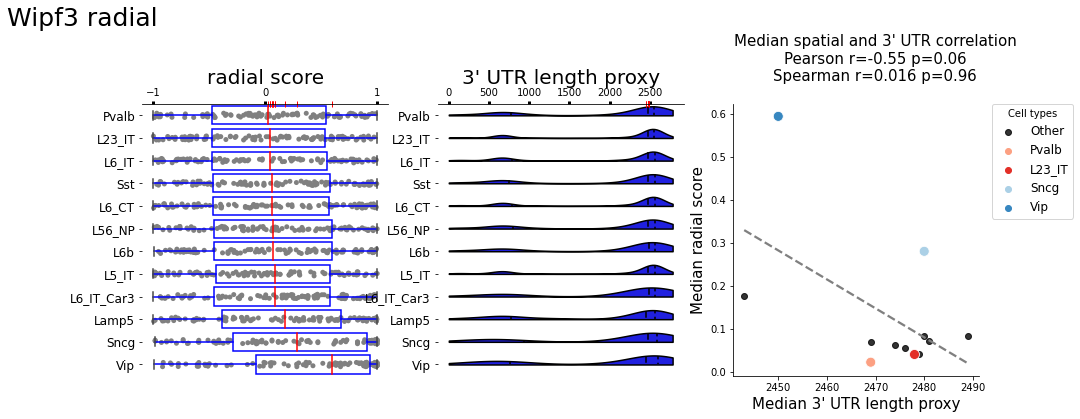

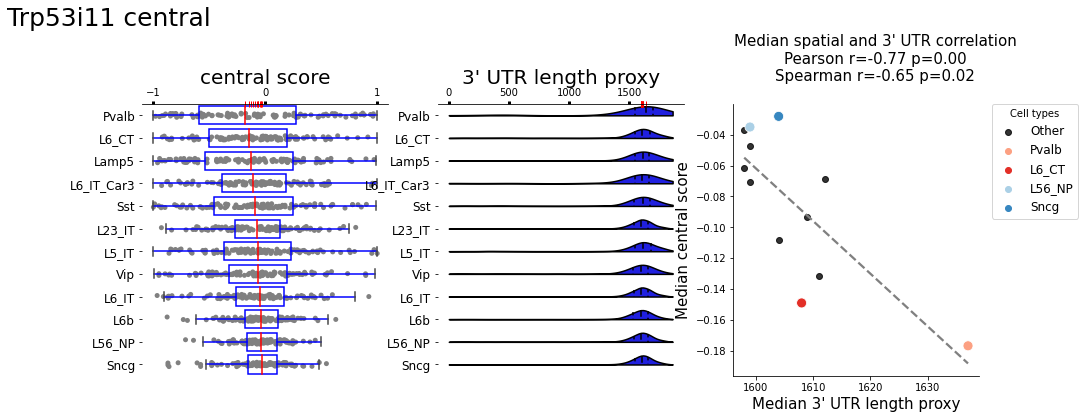

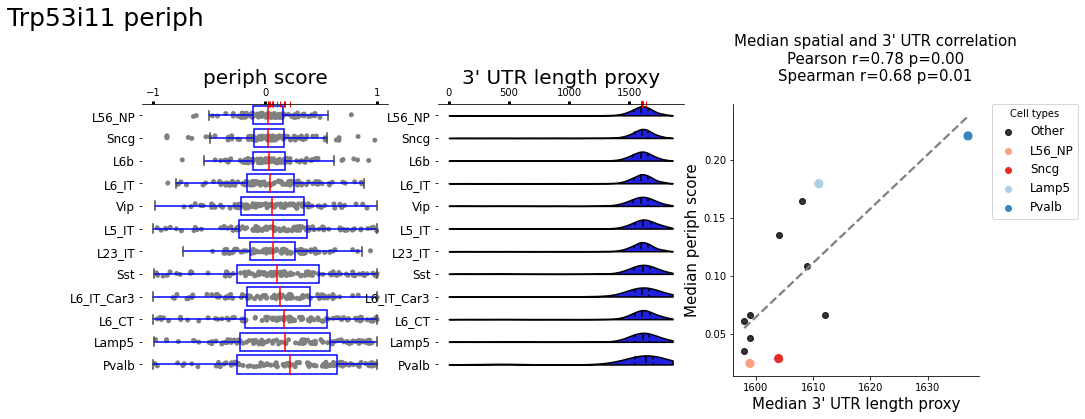

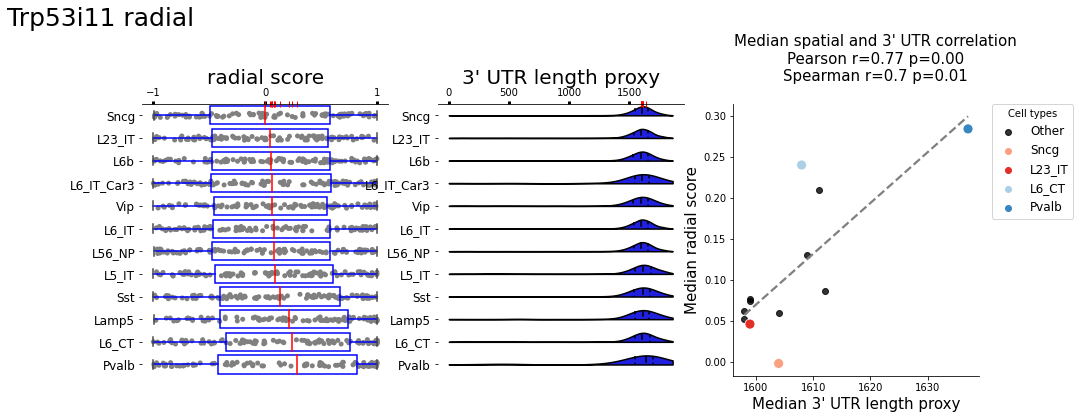

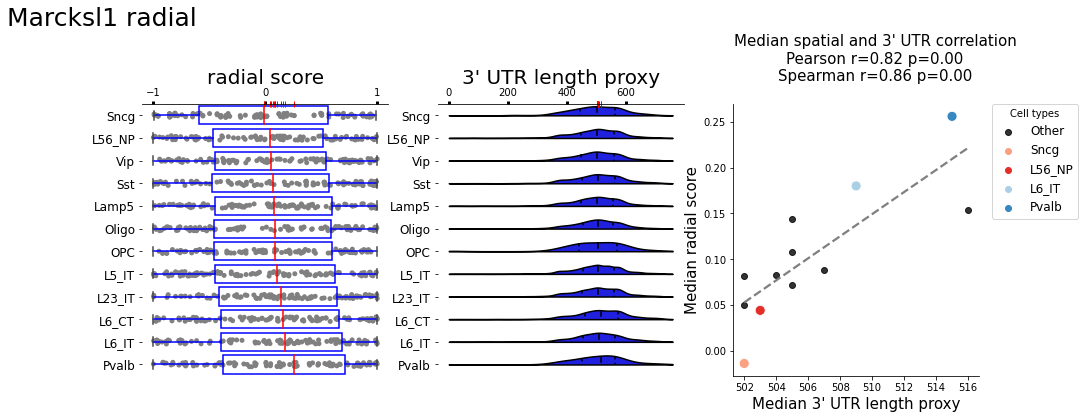

In [406]:
#these were determined to be significant from the "merfish_BICCN" notebook in this same folder

pdf = plotting.make_pdf('three_panel_significant_genes.pdf')

for i,r in sig_gene_metrics.iterrows():
    gene = r['gene']
    metric = r['metric']
    
    gene,chrom,strand,start,end = loci[loci['label'].eq(gene)].values[0]
    region = (chrom,start,end)
    read_locations = utils.bam_read_positions(bam_path, region, stratify_tag='XO')
    
    if strand == '+':
        read_locations['pos'] = read_locations['pos']-start
    else:
        read_locations['pos'] = end-read_locations['pos']
        #reverse the x-axis too?

    gene_metric_df = gene_cell_df[
        gene_cell_df['gene'].eq(gene)
        & gene_cell_df['metric'].eq(metric)
    ]
    
    fig = three_panel_slrrp_readzs(gene_metric_df, read_locations)
    plt.suptitle(
        f'{gene} {metric}', 
        x=0, y=1.15,
        horizontalalignment='left',
        verticalalignment='top',
        fontsize = 25,
    )
    pdf.savefig(fig, bbox_inches='tight')
    plt.show(fig)
    plt.close()

pdf.close()

# Appendix

Sandbox to make the three-panel plots

In [402]:
%%time
#Getting ReadZs Timp3 data
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
timp3_region = ('chr10',86345548,86349641)
read_locations = utils.bam_read_positions(bam_path, timp3_region, stratify_tag='XO')
read_locations['pos'] -= 86345548 #NOTE only currently works for plus-strand genes

#Getting SLRRP Timp3/peripheral data
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
cell_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_cells))
gene_cell_df = cell_df[cell_df['gene'].eq('Timp3') & cell_df['metric'].eq('periph')]
gene_cell_df

CPU times: user 39.3 s, sys: 6.3 s, total: 45.6 s
Wall time: 45.6 s


metric                                  cell_id annotation  \
109      periph  222098490380092065288492113826920653088     L23_IT   
385      periph  324936583968035907461485415440119465532        Vip   
463      periph  212380056445062369967464310553750468306      L6_CT   
744      periph  214530813541466051618442266501415668881      L5_IT   
869      periph  208216926404047031835800982290964847257       Endo   
...         ...                                      ...        ...   
4669313  periph  208743345960016814592334592699605472748        Vip   
4669393  periph  238521953712186391613754269351915970304      L6_CT   
4669492  periph   88420504046119131887363245653515131289     L23_IT   
4669579  periph   90158513615378526382798271915354218091      L6_CT   
4669629  periph   18521351798027225764209381587904428504       VLMC   

         num_spots   gene  num_gene_spots     score  variance    experiment  \
109            521  Timp3               2 -0.028846  0.166986  BICCN_mouse1   
385            229  Timp3               7 -0.298246  0.109136  BICCN_mouse1   
463            522  Timp3               2  0.928983  0.166985  BICCN_mouse1   
744            555  Timp3               3  0.740072  0.199997  BICCN_mouse1   
869            230  Timp3              17 -0.048035  0.049382  BICCN_mouse1   
...            ...    ...             ...       ...       ...           ...   
4669313        301  Timp3               1  0.980000  0.335556  BICCN_mouse2   
4669393        359  Timp3               1 -0.396648  0.335196  BICCN_mouse2   
4669492        757  Timp3               1 -0.806878  0.334215  BICCN_mouse2   
4669579        468  Timp3               1 -0.593148  0.334761  BICCN_mouse2   
4669629        212  Timp3              12  0.421801  0.063089  BICCN_mouse2   

        sample  
109       m1s1  
385       m1s1  
463       m1s1  
744       m1s1  
869       m1s1  
...        ...  
4669313   m2s6  
4669393   m2s6  
4669492   m2s6  
4669579   m2s6  
4669629   m2s6  

[60811 rows x 10 columns]

In [298]:
#Getting Asic4 data
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
region = ('chr1',75473492,75474351)
read_locations = utils.bam_read_positions(bam_path, region, stratify_tag='XO')
read_locations['pos'] -= 75473492 #NOTE only currently works for plus-strand genes

#Getting SLRRP Asic4/central data
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
cell_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_cells))
gene_cell_df = cell_df[cell_df['gene'].eq('Asic4') & cell_df['metric'].eq('central')]
gene_cell_df

metric                                  cell_id annotation  \
125      central  219002711125808771338247530625455951783     L23_IT   
238      central  145385588681211774057078196988290042665     L23_IT   
333      central  324936583968035907461485415440119465532        Vip   
586      central   34723182058924265408073791811691302037      L6_IT   
1087     central  316298016347899762247783698285077031502      Pvalb   
...          ...                                      ...        ...   
4668103  central  271260368793179308308603423768959610185      L6_IT   
4669142  central  338881908754195043347434596010070850417      L6_IT   
4669245  central   88420504046119131887363245653515131289     L23_IT   
4669346  central  208743345960016814592334592699605472748        Vip   
4669735  central  237641894918919763004632394087369958224      L6_IT   

         num_spots   gene  num_gene_spots     score  variance    experiment  \
125            804  Asic4               2  0.662516  0.166874  BICCN_mouse1   
238            611  Asic4               1  0.826230  0.334426  BICCN_mouse1   
333            229  Asic4               5 -0.254386  0.141582  BICCN_mouse1   
586            286  Asic4               2  0.403509  0.167247  BICCN_mouse1   
1087           760  Asic4               1  1.000000  0.334212  BICCN_mouse1   
...            ...    ...             ...       ...       ...           ...   
4668103        422  Asic4              11  0.087886  0.075453  BICCN_mouse2   
4669142        566  Asic4               8 -0.761062  0.088098  BICCN_mouse2   
4669245        757  Asic4               1  0.928571  0.334215  BICCN_mouse2   
4669346        301  Asic4              14 -0.350000  0.056178  BICCN_mouse2   
4669735        425  Asic4              15  0.457547  0.057150  BICCN_mouse2   

        sample  
125       m1s1  
238       m1s1  
333       m1s1  
586       m1s1  
1087      m1s1  
...        ...  
4668103   m2s6  
4669142   m2s6  
4669245   m2s6  
4669346   m2s6  
4669735   m2s6  

[23896 rows x 10 columns]

In [399]:
gene_cell_df['gene'].mode().values[0]

'Pou3f3'

In [400]:
def three_panel_slrrp_readzs(gene_cell_df, read_locations):
    gene = gene_cell_df['gene'].mode().values[0]
    metric = gene_cell_df['metric'].mode().values[0]
    
    #Filter SLRRP datasets
    min_gene_spots_per_cell = 1
    min_cells_per_ann = 100

    filt_gene_cell_df = (
        gene_cell_df[
            gene_cell_df['num_gene_spots'].ge(min_gene_spots_per_cell)
        ].groupby(
            'annotation'
        ).filter(
            lambda g: len(g) >= min_cells_per_ann
        )
    )

    #Filter ReadZs
    min_reads_per_ann = 100

    filt_read_locations = (
        read_locations.groupby('strat').filter(lambda g: len(g) > min_reads_per_ann)
    )

    #Find shared genes and sort them by increasing median score
    genes = set(filt_gene_cell_df['annotation']).intersection(filt_read_locations['strat'])

    filt_gene_cell_df = filt_gene_cell_df[filt_gene_cell_df['annotation'].isin(genes)]
    filt_read_locations = filt_read_locations[filt_read_locations['strat'].isin(genes)]

    gene_order = (
        filt_gene_cell_df.groupby('annotation')['score'].median()
        .sort_values()
        .index.values.tolist()
    )
    
    #Add the min and max pos as a datapoint to each cell-type for plotting
    min_pos, max_pos = filt_read_locations['pos'].min(), filt_read_locations['pos'].max()
    edge_positions = pd.DataFrame({
        'strat':gene_order*2,
        'pos':[min_pos]*len(gene_order)+[max_pos]*len(gene_order),
    })
    
    filt_read_locations = pd.concat((filt_read_locations, edge_positions))

    #Make the combined plot
    fig,(space_ax,utr_ax,corr_ax) = plt.subplots(
        figsize = (15,5),
        nrows = 1, ncols = 3,
        sharex = False, sharey = False,
    )

    ###################
    #Make the space_ax#
    ###################
    sns.boxplot(
        x = 'score',
        y = 'annotation',
        boxprops = {'facecolor':'None', 'edgecolor':'blue'},
        whiskerprops = {'color':'blue'},
        medianprops = {'color':'red'},
        fliersize = 0,
        order = gene_order,
        data = filt_gene_cell_df,
        ax = space_ax,
    )
    sns.stripplot(
        x = 'score',
        y = 'annotation',
        color = 'grey',
        order = gene_order,
        zorder = -1,
        data = filt_gene_cell_df.groupby('annotation').sample(100, replace=True), #subsample the stripplots
        ax = space_ax,
    )

    #Get median scores to add as x-axis ticks
    median_scores = list(filt_gene_cell_df.groupby('annotation')['score'].median().values)

    #Lots of personalization to remove splines and format ticks
    space_ax.spines.right.set_visible(False)
    space_ax.spines.left.set_visible(False)
    space_ax.spines.bottom.set_visible(False)
    space_ax.set_ylabel('')
    space_ax.xaxis.tick_top()
    space_ax.set_xlabel(f'{metric} score',fontsize=20)
    space_ax.xaxis.set_label_position('top')
    space_ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([-1,0,1]))
    space_ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(median_scores))
    space_ax.tick_params(
        axis='x',which='major',length=3,width=3,color='k',direction='out', labelsize=10,
    )
    space_ax.tick_params(
        axis='x',which='minor',length=6,width=1,color='r',direction='inout',
    )
    space_ax.tick_params(
        axis='y',labelsize=12,
    )

    ###################
    # Make the utr_ax #
    ###################
    #make dummy hue variable
    dummy_filt_read_locations = filt_read_locations.copy()
    dummy_filt_read_locations['_half'] = 'half' 
    dummy_df = pd.DataFrame({'strat': '_', 'pos': -1, '_half': '_'},index=[len(dummy_filt_read_locations)])
    dummy_filt_read_locations = pd.concat((dummy_filt_read_locations,dummy_df))


    sns.violinplot(
        x = 'pos',
        y = 'strat',
        hue = '_half',
        split = True,
        cut = 0,
        inner = 'quartile',
        palette = ['blue','black'], #second color never used
        order = gene_order,
        data = dummy_filt_read_locations,
        ax = utr_ax,
    )

    median_readzs_locations = list(filt_read_locations.groupby('strat')['pos'].median().values)
    utr_ax.legend([],[], frameon=False)
    utr_ax.spines.right.set_visible(False)
    utr_ax.spines.left.set_visible(False)
    utr_ax.spines.bottom.set_visible(False)
    utr_ax.set_ylabel('')
    utr_ax.set_xlabel("3' UTR length proxy",fontsize=20)
    utr_ax.xaxis.tick_top()
    utr_ax.xaxis.set_label_position('top')
    utr_ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(median_readzs_locations))
    utr_ax.tick_params(
        axis='x',which='major',length=3,width=3,color='k',direction='out', labelsize=10,
    )
    utr_ax.tick_params(
        axis='x',which='minor',length=6,width=1,color='r',direction='inout'
    )
    utr_ax.tick_params(
        axis='y',labelsize=12,
    )

    ####################
    # Make the corr_ax #
    ####################
    corr_df = pd.concat(
        (
            filt_gene_cell_df.groupby('annotation')['score'].median(),
            filt_read_locations.groupby('strat')['pos'].median()
        ),
        axis = 1,
    )
    corr_df = corr_df.loc[gene_order]
    corr_df = corr_df.reset_index()

    sns.regplot(
        x = 'pos',
        y = 'score',
        ci = None,
        line_kws = {'linestyle':'dashed','color':'grey'},
        label = 'Other',
        color = 'black',
        data = corr_df,
        ax = corr_ax,
    )
    sns.scatterplot(
        x = 'pos',
        y = 'score',
        s = 100,
        hue = 'index',
        palette = 'Reds',
        data = corr_df.head(2),
        ax = corr_ax,
    )
    sns.scatterplot(
        x = 'pos',
        y = 'score',
        s = 100,
        hue = 'index',
        palette = 'Blues',
        data = corr_df.tail(2),
        ax = corr_ax,
    )
    
    p_r,p_p = scp.stats.pearsonr(corr_df['score'], corr_df['pos'])
    s_r,s_p = scp.stats.spearmanr(corr_df['score'], corr_df['pos'])

    corr_ax.set_title(
        """
        Median spatial and 3' UTR correlation
        Pearson r={:.2} p={:.2f}
        Spearman r={:.2} p={:.2f}
        """.format(p_r,p_p,s_r,s_p),
        fontsize=15
    )
    corr_ax.set_xlabel("Median 3' UTR length proxy",fontsize=15)
    corr_ax.set_ylabel(f'Median {metric} score',fontsize=15)
    corr_ax.legend(
        title='Cell types',
        loc=2,
        bbox_to_anchor=(1.05, 1),
        ncol=1,
        borderaxespad=0.,
        fontsize=12,
    )
    corr_ax.spines.right.set_visible(False)
    corr_ax.spines.top.set_visible(False)

    return fig


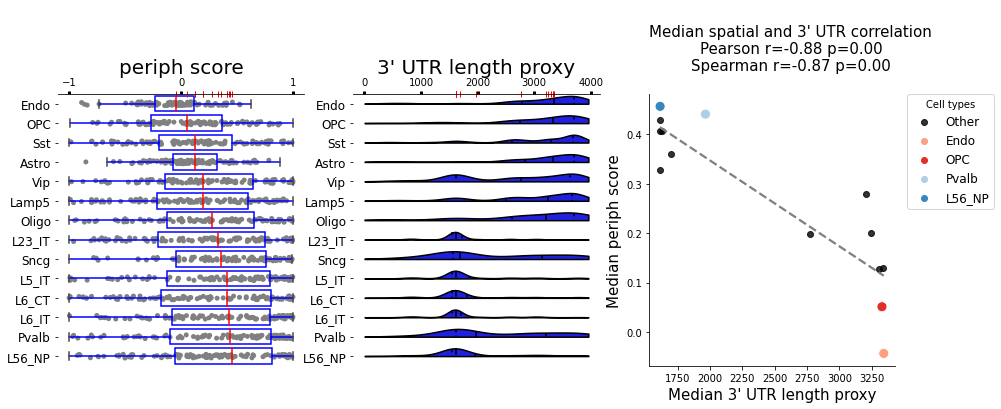

CPU times: user 1.54 s, sys: 15.1 ms, total: 1.56 s
Wall time: 1.67 s


In [403]:
%%time
fig = three_panel_slrrp_readzs(gene_cell_df, read_locations)
plt.savefig('Timp3_three_panel.svg')
plt.show(fig)
plt.close()

-0.9068972619043055 1.896480450193062e-05
